# Visual NLP Handwritten and Signature detection
## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

##Colab Setup

In [5]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12"

## Initialization of spark session


In [6]:
from pyspark.sql import SparkSession
from sparkocr import start
import os

if license:
    os.environ['SPARK_OCR_LICENSE'] = license

spark = start(jar_path = spark_ocr_jar_path)
spark

Spark version: 3.2.1
Spark NLP version: 5.3.0
Spark NLP for Healthcare version: 5.2.1
Spark OCR version: 5.3.1rc3



## Run Spark-ocr

Generate result.

In [7]:
import sparkocr
import sys
from pyspark.sql import SparkSession
import os
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.enums import *
from sparknlp.annotator import *
from sparknlp.base import *
from sparkocr.utils import display_images, display_tables, display_dicom


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


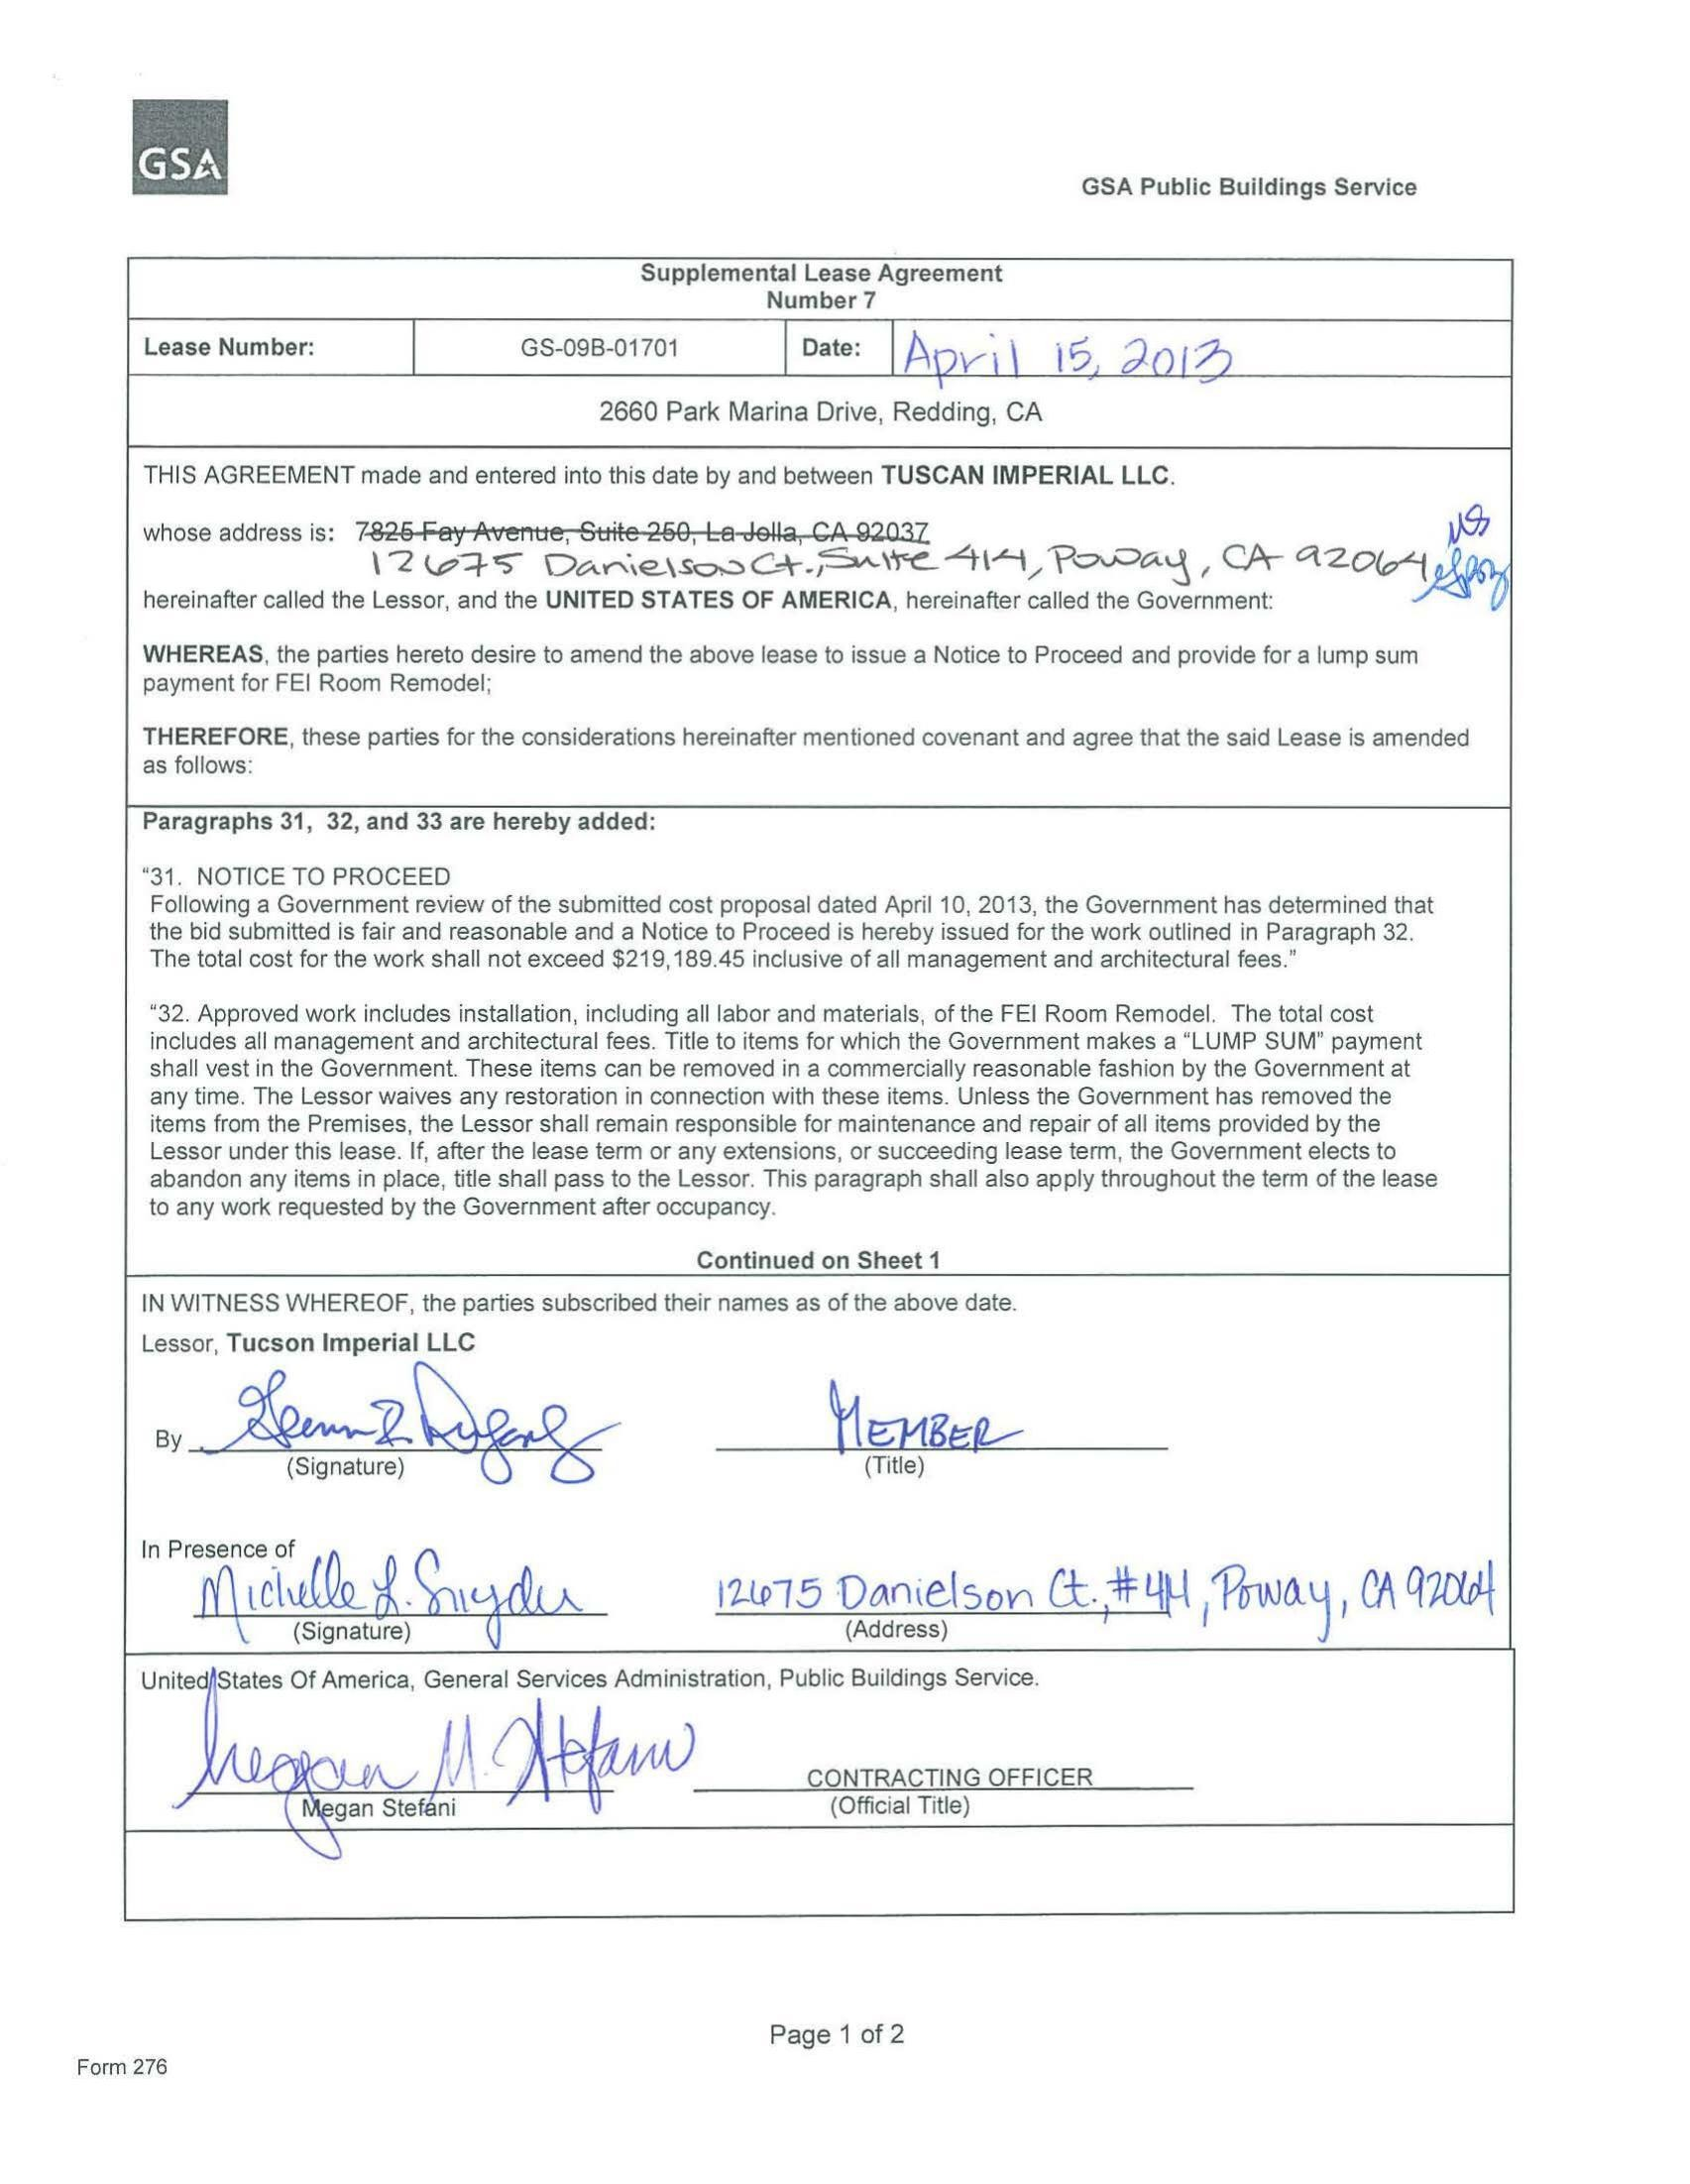

In [10]:
imagePath = "./data/handwritten/page1.jpeg"
image_df = spark.read.format("binaryFile").load(imagePath).sort("path")
display_images(BinaryToImage().setImageType(ImageType.TYPE_3BYTE_BGR).transform(image_df), "image")

##Define OCR transformers and pipeline

In [11]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

# Detect labels to deidentified in the input document
text_detector = ImageDocumentRegionDetector \
    .pretrained("image_handwritten_detector_jsl", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("regions") \
    .setScoreThreshold(0.25)

# Draw filled rectangle for hide sensitive data
draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("regions") \
    .setOutputCol("image_with_regions") \
    .setFilledRect(False) \
    .setRectColor(Color.gray)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    text_detector,
    draw_regions
])

image_handwritten_detector_jsl download started this may take some time.
Approximate size to download 265.9 MB



    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


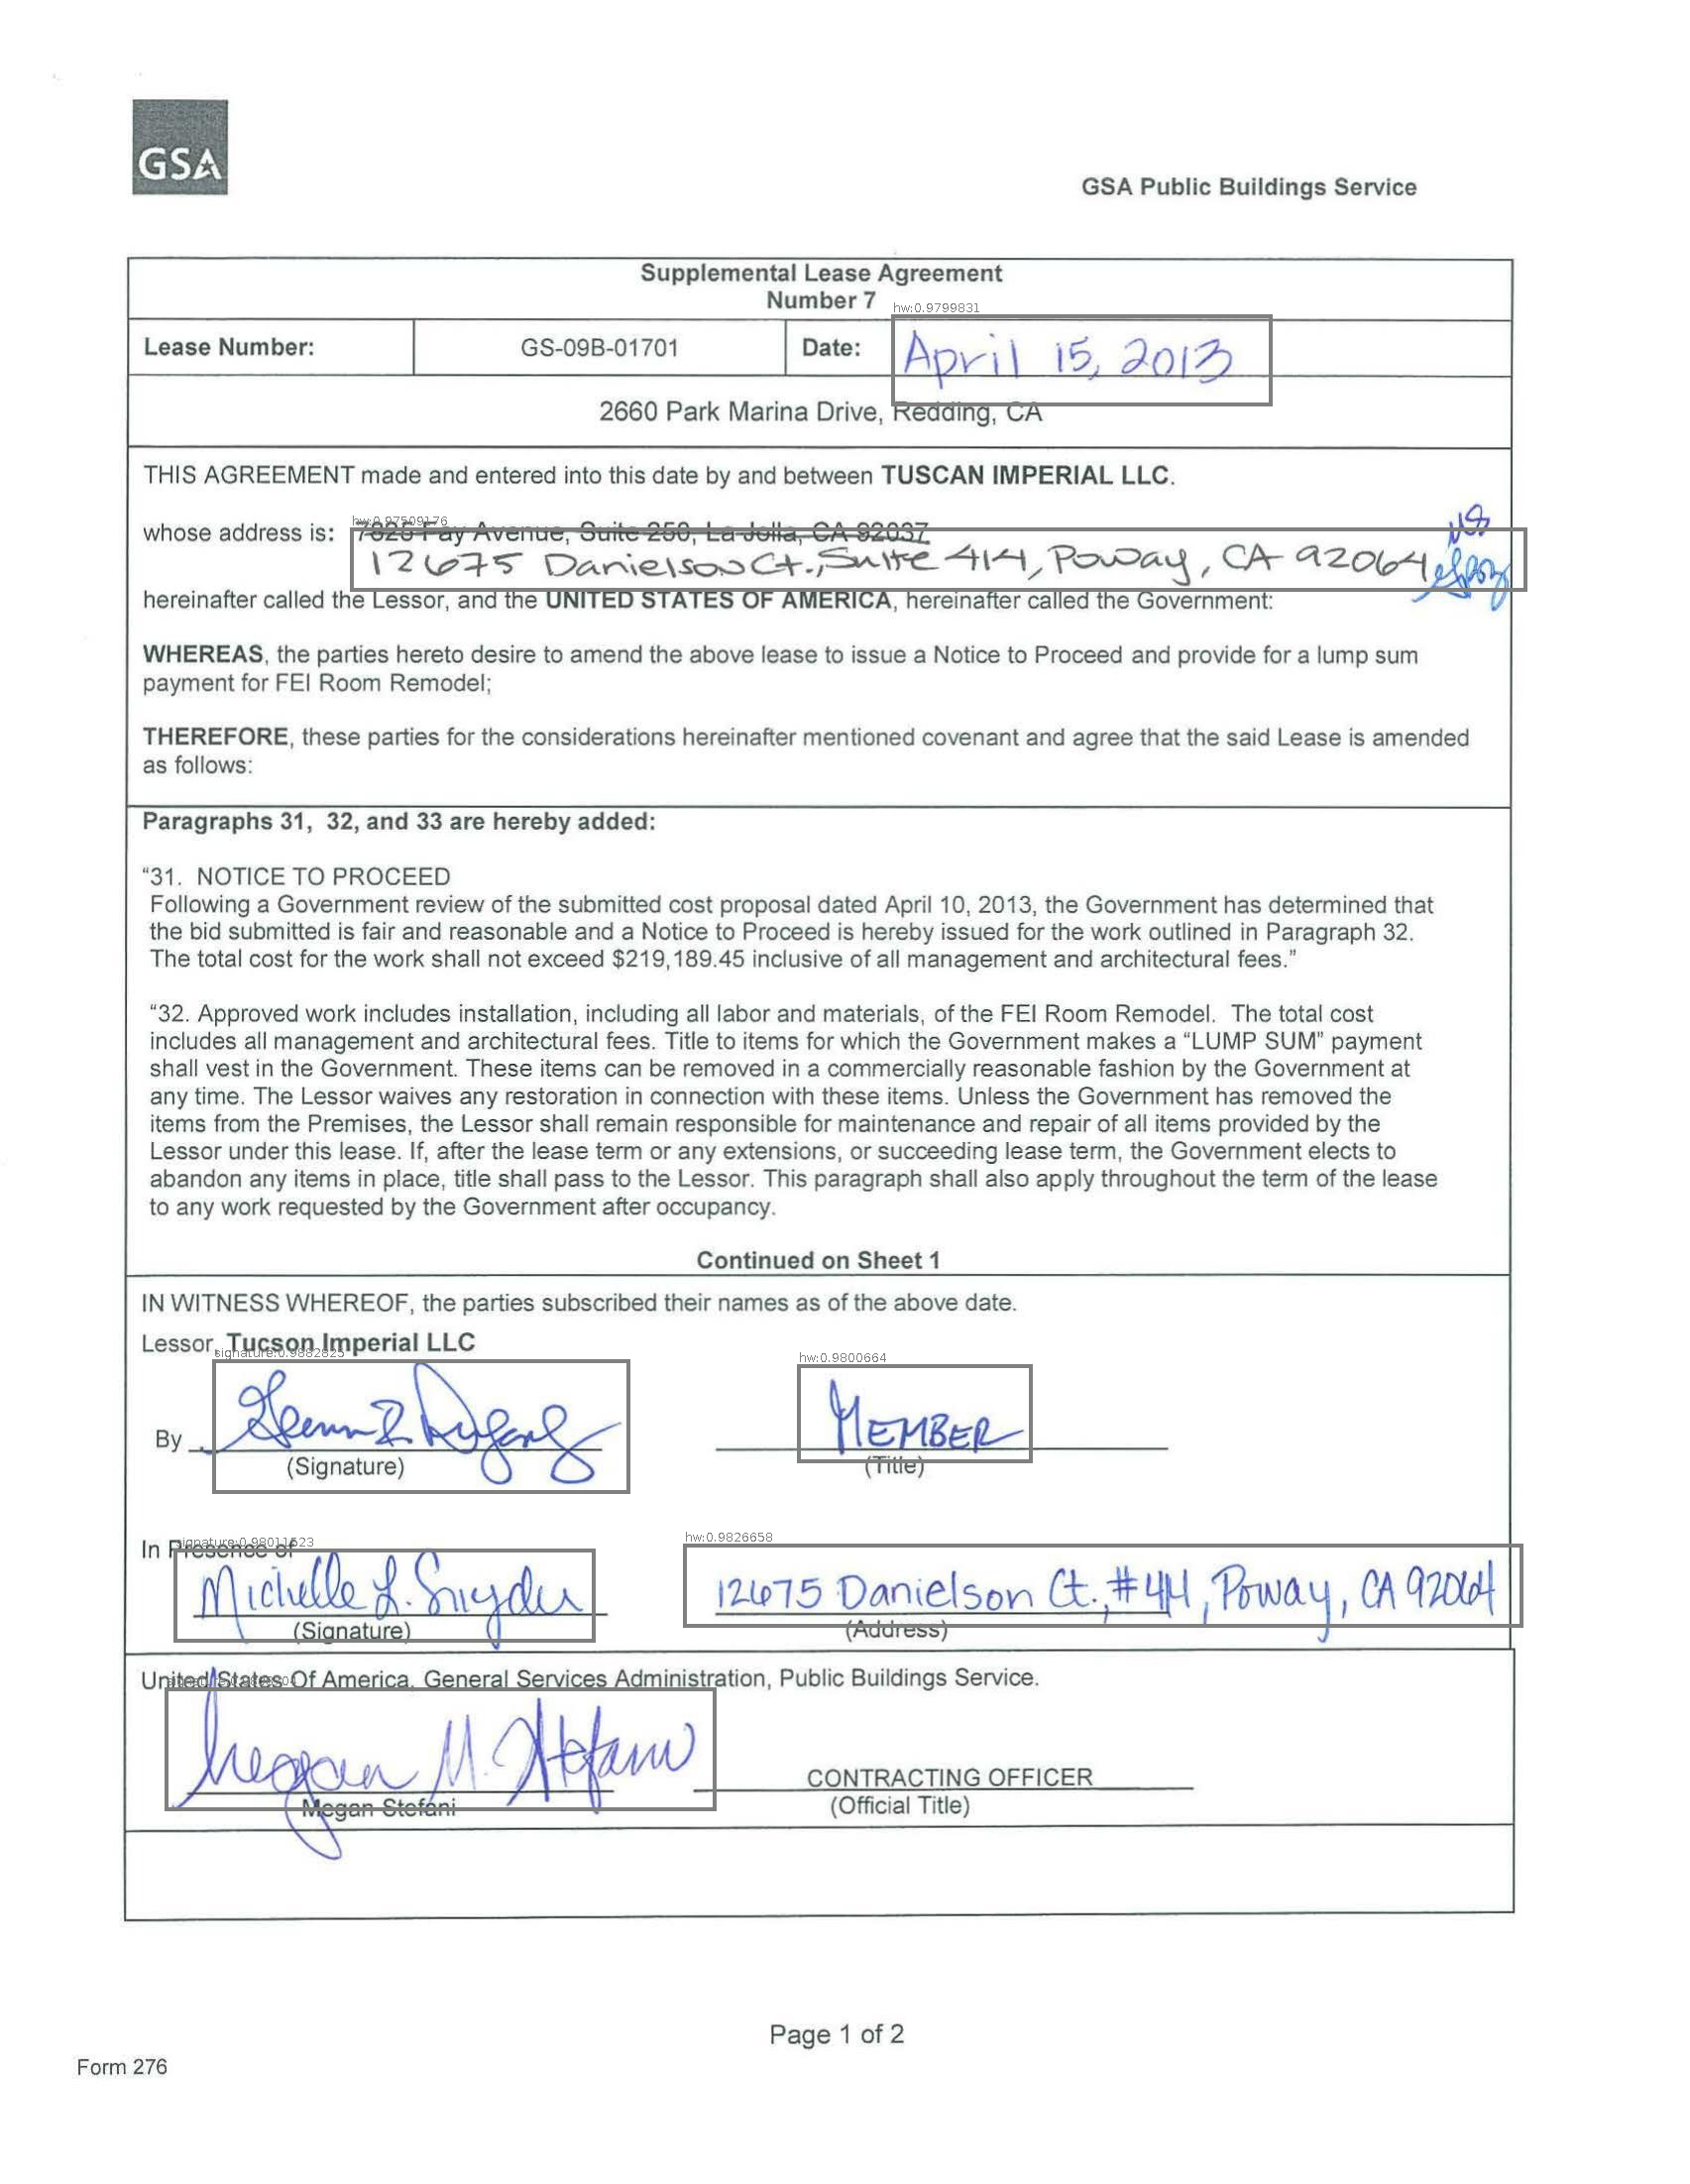

In [12]:
result = pipeline.transform(image_df)
display_images(result, "image_with_regions")